In [1]:
# !pip install fasttext-langdetect

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
from ftlangdetect import detect
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

Here's a description for each column of **Discourse forums** dataset:

### Common columns for all posts:
1. **forum**: The specific forum where the topic is located.
2. **type**: The category of the post message: `topic_starter` or `reply`
3. **author_username**: The username of the author who created the post.
4. **author_name**: The real name or display name of the author who created the post.
5. **created**: The date and time when the post was created.
6. **body**: The main HTML-raw content of the topic post.
7. **body_md**: The content of the post in Markdown format.

### Related for `topic_starter` posts:
1. **topic_url**: The URL link to the forum topic.
2. **topic_id**: A unique identifier for the forum topic.
3. **topic_title**: The title or subject of the forum topic.
4. **topic_views**: The total number of times the forum topic has been viewed.
5. **topic_likes**: The number of likes or upvotes the topic has received.
6. **topic_participant_count**: The number of unique participants or users involved in the topic discussion.
7. **topic_reads**: The number of times the topic was read.
8. **topic_readers_count**: The number of unique users who have read the topic.
9. **topic_score**: A calculated score for the topic, possibly based on likes, views, and other engagement metrics.
10. **topic_pinned**: A binary flag indicating whether the topic is pinned or sticky at the top of the forum.
11. **topic_links**: URLs or links mentioned within the topic.
12. **word_count**: The number of words in the topic post.
13. **number_of_posts**: The total number of posts or replies in the topic thread.
14. **posts_ids**: List or array of unique identifiers for each `reply` post in the topic.


### Related for `reply` posts:
1. **post_number**: The chronological order or sequence number of the post within the topic.
2. **post_id**: A unique identifier for each individual post or reply.
3. **post_score**: A calculated score for the post, possibly based on likes, views, and other engagement metrics.
4. **post_reads**: The number of times the post has been read.
5. **post_readers_count**: The number of unique users who have read the post.



These descriptions should help in understanding the nature and significance of each column in dataset.

In [39]:
# Loading dataset 
dataset = load_dataset('bigcode/discourse_forums', token='...', split='train')

Resolving data files:   0%|          | 0/61 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/61 [00:00<?, ?it/s]

In [275]:
# Here are 25 million posts in the dataset
len(dataset)

25637209

In [ ]:
# Basic filter
dataset = dataset.filter(lambda x: (x['body_md'] is not None) and len(x['body_md']) >1, num_proc=16)

In [270]:
# Here we are going to calculate some statistics for exploration

tokenizer = AutoTokenizer.from_pretrained('bigcode/starcoder', token='...')

def add_meta(sample):
    return dict(
        has_github_link = 'github.com' in sample['body'],
        has_code = '<code>' in sample['body'],
        lang = detect(sample['body_md'].replace('\n',' '))['lang'],
        num_tokens = len(tokenizer.tokenize(sample['body_md']))
    )

dataset = dataset.map(add_meta, num_proc=64)

In [151]:
# Convert data from some columns to pd.DataFrame

remove_columns = list(set(dataset.features.keys()) - {
    'forum', 
    'topic_url', 
    'topic_id', 
    'topic_views',
    'number_of_posts', 
    'has_github_link',
    'has_code',
    'lang',
    'num_tokens'
})
index_df = dataset.remove_columns(remove_columns).to_pandas()

In [157]:
index_df['num_tokens'].sum() # here are 5.5B tokens

5521315877

## Visual exploration of sampled topics

In [96]:
from IPython.display import display, HTML, Markdown

def display_topic(forum=None, topic_id=None, topic_url=None):
    assert ((forum is not None) and (topic_id is not None)) or topic_url is not None
    if topic_url:
        idx = index_df['topic_url'] == topic_url
    else:
        idx = (index_df['forum']==forum) & (index_df['topic_id']==topic_id)
    
    topic = dataset[index_df[idx].index]

    display(Markdown(f"# [{next(title for title in topic['topic_title'] if title)}]({topic['topic_url'][0]})"))
    for username, post in zip(topic['author_username'], topic['body_md']):
        display(Markdown(f"#### >> post by `{username}`"))
        display(Markdown(post))

def sample_topic():
    display_topic(topic_url = index_df.topic_url.sample(1).item())

### Now, let's quickly take a glance at the sample topics in the dataset. For our first example, we'll consider https://discuss.huggingface.co/t/qlora-trained-llama2-13b-deployment-error-on-sagemaker-using-text-generation-inference-image/48154**

In [89]:
display_topic(forum='discuss.huggingface.co', topic_id=48154)

# [QLoRA trained LLaMA2 13B deployment error on Sagemaker using text generation inference image](https://discuss.huggingface.co/t/qlora-trained-llama2-13b-deployment-error-on-sagemaker-using-text-generation-inference-image/48154)

#### >> post by `rycfung`

I was following the article [here](https://www.philschmid.de/sagemaker-llama2-qlora#3-fine-tune-llama-13b-with-qlora-on-amazon-sagemaker) to train the llama2 13b model.

But when I try to deploy with TGI container, I’m running into this error:

```
#033[2m2023-07-25T19:44:12.555090Z#033[0m #033[31mERROR#033[0m #033[1mshard-manager#033[0m: #033[2mtext_generation_launcher#033[0m#033[2m:#033[0m Error when initializing model
"Traceback (most recent call last):
  File ""/opt/conda/bin/text-generation-server"", line 8, in 
 sys.exit(app())
 File ""/opt/conda/lib/python3.9/site-packages/typer/main.py"", line 311, in \_\_call\_\_
 return get\_command(self)(\*args, \*\*kwargs)
 File ""/opt/conda/lib/python3.9/site-packages/click/core.py"", line 1130, in \_\_call\_\_
 return self.main(\*args, \*\*kwargs)
 File ""/opt/conda/lib/python3.9/site-packages/typer/core.py"", line 778, in main
 return \_main(
 File ""/opt/conda/lib/python3.9/site-packages/typer/core.py"", line 216, in \_main
 rv = self.invoke(ctx)
 File ""/opt/conda/lib/python3.9/site-packages/click/core.py"", line 1657, in invoke
 return \_process\_result(sub\_ctx.command.invoke(sub\_ctx))
 File ""/opt/conda/lib/python3.9/site-packages/click/core.py"", line 1404, in invoke
 return ctx.invoke(self.callback, \*\*ctx.params)
 File ""/opt/conda/lib/python3.9/site-packages/click/core.py"", line 760, in invoke
 return \_\_callback(\*args, \*\*kwargs)
 File ""/opt/conda/lib/python3.9/site-packages/typer/main.py"", line 683, in wrapper
 return callback(\*\*use\_params) # type: ignore
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/cli.py"", line 67, in serve
 server.serve(model\_id, revision, sharded, quantize, trust\_remote\_code, uds\_path)
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/server.py"", line 155, in serve
 asyncio.run(serve\_inner(model\_id, revision, sharded, quantize, trust\_remote\_code))
 File ""/opt/conda/lib/python3.9/asyncio/runners.py"", line 44, in run
 return loop.run\_until\_complete(main)
 File ""/opt/conda/lib/python3.9/asyncio/base\_events.py"", line 634, in run\_until\_complete
 self.run\_forever()
 File ""/opt/conda/lib/python3.9/asyncio/base\_events.py"", line 601, in run\_forever
 self.\_run\_once()
 File ""/opt/conda/lib/python3.9/asyncio/base\_events.py"", line 1905, in \_run\_once
 handle.\_run()
 File ""/opt/conda/lib/python3.9/asyncio/events.py"", line 80, in \_run
 self.\_context.run(self.\_callback, \*self.\_args)"
"> File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/server.py"", line 124, in serve\_inner
 model = get\_model(model\_id, revision, sharded, quantize, trust\_remote\_code)
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/models/\_\_init\_\_.py"", line 246, in get\_model
 return llama\_cls(
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/models/flash\_llama.py"", line 58, in \_\_init\_\_
 filenames = weight\_files(model\_id, revision, "".bin"")
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/utils/hub.py"", line 86, in weight\_files
 raise FileNotFoundError("
"FileNotFoundError: No local weights found in /opt/ml/model with extension .bin
 #033[2m#033[3mrank#033[0m#033[2m=#033[0m0#033[0m"
#033[2m2023-07-25T19:44:13.212448Z#033[0m #033[31mERROR#033[0m #033[2mtext\_generation\_launcher#033[0m#033[2m:#033[0m Shard 0 failed to start:
"Traceback (most recent call last):
 File ""/opt/conda/bin/text-generation-server"", line 8, in 
 sys.exit(app())
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/cli.py"", line 67, in serve"
"Error: ShardCannotStart
 server.serve(model\_id, revision, sharded, quantize, trust\_remote\_code, uds\_path)
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/server.py"", line 155, in serve
 asyncio.run(serve\_inner(model\_id, revision, sharded, quantize, trust\_remote\_code))
 File ""/opt/conda/lib/python3.9/asyncio/runners.py"", line 44, in run
 return loop.run\_until\_complete(main)
 File ""/opt/conda/lib/python3.9/asyncio/base\_events.py"", line 647, in run\_until\_complete
 return future.result()
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/server.py"", line 124, in serve\_inner
 model = get\_model(model\_id, revision, sharded, quantize, trust\_remote\_code)
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/models/\_\_init\_\_.py"", line 246, in get\_model
 return llama\_cls(
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/models/flash\_llama.py"", line 58, in \_\_init\_\_
 filenames = weight\_files(model\_id, revision, "".bin"")
 File ""/opt/conda/lib/python3.9/site-packages/text\_generation\_server/utils/hub.py"", line 86, in weight\_files
 raise FileNotFoundError("
FileNotFoundError: No local weights found in /opt/ml/model with extension .bin

```

I use this code to deploy

```
from sagemaker.huggingface import get_huggingface_llm_image_uri

# retrieve the llm image uri
llm_image = get_huggingface_llm_image_uri(
  "huggingface",
  version="0.8.2"
)

# print ecr image uri
print(f"llm image uri: {llm_image}")

import json
from sagemaker.huggingface import HuggingFaceModel

# sagemaker config
instance_type = "ml.g5.2xlarge"
number_of_gpu = 1
health_check_timeout = 300

# Define Model and Endpoint configuration parameter
config = {
  'HF_MODEL_ID': "/opt/ml/model",
  'SM_NUM_GPUS': json.dumps(number_of_gpu), # Number of GPU used per replica
  'MAX_INPUT_LENGTH': json.dumps(2048),  # Max length of input text
  'MAX_TOTAL_TOKENS': json.dumps(4096),  # Max length of the generation (including input text)
  # 'HF_MODEL_QUANTIZE': "bitsandbytes", # comment in to quantize
}

# create HuggingFaceModel with the image uri
llm_model = HuggingFaceModel(
  model_data=f"s3://sagemaker-us-east-1-535772764458/huggingface-qlora-2023-07-24-21-27-30-2023-07-24-21-30-34-443/output/model.tar.gz",  # Change to your model path
  role=role,
  image_uri=llm_image,
  env=config
)

llm = llm_model.deploy(
  initial_instance_count=1,
  instance_type=instance_type,
  # volume_size=400, # If using an instance with local SSD storage, volume_size must be None, e.g. p4 but not p3
  container_startup_health_check_timeout=health_check_timeout, # 10 minutes to be able to load the model
)

```

The trained model is made public in the s3 uri above in case that helps with debugging.

#### >> post by `Jorgeutd`

I haven’t been successful with the new llm hosting version “0.8.2” in Sagemaker. However, I managed to deploy the output trained model using custom inference code (def model\_fn(model\_dir) and predict\_fn(data, model\_and\_tokenizer).

I opened a similar issues here:

![](https://avatars.discourse-cdn.com/v4/letter/m/e47774/48.png)
[Deploying Fine-Tune Falcon 40B with QLoRA on Sagemaker Inference Error](https://discuss.huggingface.co/t/deploying-fine-tune-falcon-40b-with-qlora-on-sagemaker-inference-error/46841/23) [Amazon SageMaker](/c/sagemaker/17)

> 
>  I didn’t get 7b working with TGI container image 0.8.2 ([763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-tgi-inference:2.0.0-tgi0.8.2-gpu-py39-cu118-ubuntu20.04](http://763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-tgi-inference:2.0.0-tgi0.8.2-gpu-py39-cu118-ubuntu20.04)). 
> Building the latest TGI container image for SageMaker ([GitHub - huggingface/text-generation-inference at v0.9.3](https://github.com/huggingface/text-generation-inference/tree/v0.9.3)) and the other instructions I described above was what makes 7b work for me. 
> I don’t have the time right now to train a 40b with my instructions. 
> If you have time maybe you can try my instructions with 7b o…
>  

If you find any solutions please let me know.

#### >> post by `rycfung`

Thanks [@Jorgeutd](/u/jorgeutd), do you mind sharing your inference.py file? Did you also override with a new requirements.txt? Now that my image is written to s3, how do I get a new inference.py into the tarball (other than downloading it, unzipping it, re-tar it with the new inference.py, which will be pretty time consuming)?

[@philschmid](/u/philschmid) since 0.8.2 is still expecting .bin files, is there any way to override during the deployment so it plays nicely with only safetensors file? And are there plans to push the 0.9.3 version of the tgi image any time soon?

#### >> post by `rycfung`

Following example below, I’m trying to build 0.9.3 in the hopes that it would solve my issue with deploying the model with only .safetensor files.

![](https://avatars.discourse-cdn.com/v4/letter/m/e47774/48.png)
[Deploying Fine-Tune Falcon 40B with QLoRA on Sagemaker Inference Error](https://discuss.huggingface.co/t/deploying-fine-tune-falcon-40b-with-qlora-on-sagemaker-inference-error/46841/20) [Amazon SageMaker](/c/sagemaker/17)

> 
>  Hi, 
> Note: I can only post 2 links because my account is new. See the next posts for all the missing links. 
> We have successfully deployed a fine-tuned Falcon 7B & Falcon 7B instruct model to an Amazon SageMaker inference endpoint. 
> The scripts/requirements.txt are the same as in [@philschmid](/u/philschmid)’s [update](https://discuss.huggingface.co/t/deploying-fine-tune-falcon-40b-with-qlora-on-sagemaker-inference-error/46841/8). 
> In the scripts/run\_clm.py file we added 
> 
> modules\_to\_save=["lm\_head"] to the LoraConfig below [line 79](https://github.com/huggingface/notebooks/blob/764f7085708ccf3567eac22024883e9e9222e180/sagemaker/28_train_llms_with_qlora/scripts/run_clm.py#L79)
> trust\_remote\_code=True to the AutoPeftModelForCausalLM.from\_pretrained parameters in line 163.
> …
>  

How did you manage to build the docker image [@malterei](/u/malterei)? I’ve tried build in on my M1 Macbook (which fails since it looks like the dockerfile has a hardcoded `exit 1` when arch is arm64), as well as several instance types on ec2. All of them eventually gets stuck at this stage because it has consume all of the instance’s memory:

```
 => [vllm-builder 3/3] RUN make build-vllm                                             69.5s
 => => # python3.9/site-packages/torch/include/TH -I/opt/conda/lib/python3.9/site-packages/t
 => => # orch/include/THC -I/opt/conda/include -I/opt/conda/include/python3.9 -c -c /usr/src
 => => # /vllm/csrc/cache.cpp -o /usr/src/vllm/build/temp.linux-x86_64-cpython-39/csrc/cache
 => => # .o -g -O2 -std=c++17 -D_GLIBCXX_USE_CXX11_ABI=0 -DTORCH_API_INCLUDE_EXTENSION_H '-D
 => => # PYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_A
 => => # BI="_cxxabi1011"' -DTORCH_EXTENSION_NAME=vllm_cache_ops -D_GLIBCXX_USE_CXX11_ABI=0
 => CACHED [planner 7/7] RUN cargo chef prepare --recipe-path recipe.json               0.0s
 => CACHED [builder  2/10] COPY --from=planner /usr/src/recipe.json recipe.json         0.0s
 => CACHED [builder  3/10] RUN cargo chef cook --release --recipe-path recipe.json      0.0s
 => CACHED [builder  4/10] COPY Cargo.toml Cargo.toml                                   0.0s
 => CACHED [builder  5/10] COPY rust-toolchain.toml rust-toolchain.toml                 0.0s
 => CACHED [builder  6/10] COPY proto proto                                             0.0s
 => CACHED [builder  7/10] COPY benchmark benchmark                                     0.0s
 => CACHED [builder  8/10] COPY router router                                           0.0s
 => CACHED [builder  9/10] COPY launcher launcher                                       0.0s
 => CACHED [builder 10/10] RUN cargo build --release                                    0.0s

```

I’ve tried building 0.9.3 and 0.9.2, both are resulting in some error when it hits `build-vllm`. Am I missing something?

#### >> post by `Jorgeutd`

%%writefile model/code/inference.py

lets deploy the falcon 7B model for inference
=============================================

import torch  

import torch.nn as nn  

from transformers import AutoModelForCausalLM, AutoTokenizer  

import os  

import json  

from peft import LoraConfig , get\_peft\_model , TaskType , prepare\_model\_for\_int8\_training , PeftConfig, PeftModel

def model\_fn(model\_dir):  

# load model and processor from model\_dir  

model = AutoModelForCausalLM.from\_pretrained(model\_dir,  

device\_map=“auto”,  

torch\_dtype=torch.bfloat16,  

low\_cpu\_mem\_usage=True,  

trust\_remote\_code=True)

```
tokenizer = AutoTokenizer.from_pretrained(model_dir)

return model, tokenizer

```

def predict\_fn(data, model\_and\_tokenizer):  

# unpack model and tokenizer  

model, tokenizer = model\_and\_tokenizer

```
# process input
inputs = data.pop("inputs", data)
parameters = data.pop("parameters", None)

# preprocess
input_ids = tokenizer(inputs, return_tensors="pt").input_ids.to(model.device)

# pass inputs with all kwargs in data
if parameters is not None:
    outputs = model.generate(input_ids, **parameters)
else:
    outputs = model.generate(input_ids)

# postprocess the prediction
prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

return [{"generated_text": prediction}]

```

Yes, I changed the req file with new transformers version.

#### >> post by `sdkramer10`

Can someone push up the the 0.9.3 image with --target sagemaker to dockerhub? I’m unable to build it on my local machine.

#### >> post by `philschmid`

Yesterday night the new iamge got released: [Release v1.0-hf-tgi-0.9.3-pt-2.0.1-inf-gpu-py39 · aws/deep-learning-containers · GitHub](https://github.com/aws/deep-learning-containers/releases/tag/v1.0-hf-tgi-0.9.3-pt-2.0.1-inf-gpu-py39)  

Its not yet available in the `sagemaker-sdk` but you can use the URI directly.

#### >> post by `Jorgeutd`

Thank you [@philschmid](/u/philschmid) for all your work.

With this new release all the issues regarding deploying fine tuned models with LLM Inference image will be fix it?

#### >> post by `elodium`

Hi,  

I am using the config [@rycfung](/u/rycfung) used but with deploying finetuned llama-13b (QLoRA-merged) on 4xlarge instance.

I am getting cudaOutOfMemoryError and I got confused why that happen. Because I did use 4xlarge on the finetuning, and it is really mysterious that why would the inference require larger gpu cluster than the finetuning itself where it is more computationally expensive?

2023-08-05T10:17:44.741-05:00

Copy  

torch.cuda.OutOfMemoryError: Allocation on device 0 would exceed allowed memory. (out of memory)  

torch.cuda.OutOfMemoryError: Allocation on device 0 would exceed allowed memory. (out of memory)

2023-08-05T10:17:44.741-05:00 Currently allocated : 21.13 GiB

2023-08-05T10:17:44.741-05:00 Requested : 150.00 MiB

2023-08-05T10:17:44.741-05:00 Device limit : 22.20 GiB

2023-08-05T10:17:44.741-05:00 Free (according to CUDA): 25.12 MiB

2023-08-05T10:17:46.246-05:00 PyTorch limit (set by user-supplied memory fraction) : 17179869184.00 GiB

#### >> post by `sdkramer10`

I’m pretty sure it’s because with LoRA techniques, you only need to load the smaller matrix of weights that are being fine-tuned on to the GPUs, since only those weights are being updated. However, during inference all of the weights need to be loaded on to GPUs.

#### >> post by `rycfung`

[@elodium](/u/elodium) I ended up building the 0.9.3 image from scratch (which was half a day of work between actual compiling building and figuring out some build configurations to make the build stop freezing/blowing all of the memory even with 100GB of RAM on EC2).

I ended up deploying with the TGI 0.9.3 image I built on a g5.4xlarge, and it worked. Only issue was even though I deployed the 4-bit QLoRA LLaMA 2 13B, generation was pretty slow, and often freeze on the sagemaker deployment or times out after 30s. That was super odd because I was expecting the 4bit quantized 13B to breeze thru the generation on a 4xlarge.

Going to try the official 093 image to see if there’s a difference.

#### >> post by `elodium`

[@rycfung](/u/rycfung) I use the tgi 0.9 and not specific to 0.9.3 and i have successfully deployed my finetuned model on ml.g5.12xlarge endpoint. Have you resolved the issue?

#### >> post by `rycfung`

Yes, I was able to deploy with 093, was pretty slow to generate though. Wonder what the generation speed was like for you [@elodium](/u/elodium).

#### >> post by `efy9002`

Im running into the same issue… but running into the error even when using a ml.g5.12xlarge… [Deploy Llama 2 7B/13B/70B on Amazon SageMaker](https://www.philschmid.de/sagemaker-llama-llm)

Is there a setting we’re missing that is preventing us from using the smaller instances [@philschmid](/u/philschmid) ?

(I am downloading the model from HF and loading locally because my endpoint needs to have network isolation)

#### >> post by `efy9002`

Nevermind, this was fixed, by either re-cloning the model repo or including of the ‘MAX\_BATCH\_TOTAL\_TOKENS’: json.dumps(8192) parameter in the model config.

### The next topic we are going to explore is https://devforum.roblox.com/t/groups-api-being-randomly-rate-limited/705102

In [99]:
sample_topic()

# [Groups Api being randomly rate limited?](https://devforum.roblox.com/t/groups-api-being-randomly-rate-limited/705102)

#### >> post by `Etheroit`

Hello!

Since today, around 18:14 UTC, Roblox api (specifically groups one - <https://groups.roblox.com/> ) started throwing rate limits.

For me it starts after around 5 requests, but it’s pretty random (I’ve messaged [@grilme99](/u/grilme99) to ask if he can reproduce this issue, and he was rate limitted on first try).

Tested endpoint:  

<https://groups.roblox.com/v1/users/21735007/groups/roles> (Refresh at least 6 times)

I’ve observed that limitation seems to be per IP. Sometimes a 200 code appears after 429, then another is again rate limitted.

Is this a new feature released to Roblox API? If so, that limit seems to be really low (is it documented anywhere? I don’t recall seeing any announcement regarding such change) and it would be extremely easier if headers letting us know about restrictions were shown (for example just like Discord does - <https://discord.com/developers/docs/topics/rate-limits#header-format> )

#### >> post by `Iron_Legion`

We are temporarily rate-limiting the Groups API to avoid the 500 Internal Server Errors seen in previous threads. We plan to remove this rate limit later this week once we have made some scaling improvements.

For now, we have loosened the rate limiting a little bit.

![](https://doy2mn9upadnk.cloudfront.net/user_avatar/devforum.roblox.com/popeeyy/40/2402177_2.png)
[Increase In HTTP 500 Errors On API Endpoints](https://devforum.roblox.com/t/increase-in-http-500-errors-on-api-endpoints/696404) [Website Bugs](/c/bug-reports/website-bugs/30)

> 
>  2 days ago, I started getting a disturbing amount of random HTTP 500 errors returned from Roblox when ranking users. They come in random bursts and usually lasted around a few minutes. However, now Roblox games are being affected more by this bug and functions like GetRankInGroup are starting to fail for some people. The errors usually happened in bursts, but now it’s happening more frequently and is just coming up random at this point. Sometimes the error will occur many times in a row after re…
>  

I would recommend wrapping your API calls in a way such that they can be retried after waiting a few seconds when you get a 429 error.

#### >> post by `Etheroit`

Is it possible to get any detailed information about current ratelimit settings?

#### >> post by `buildthomas`

![](https://doy2mn9upadnk.cloudfront.net/user_avatar/devforum.roblox.com/iron_legion/40/799726_2.png) Iron\_Legion:

> 
> I would recommend wrapping your API calls in a way such that they can be retried after waiting a few seconds when you get a 429 error.
> 
> 
> 

Would be cool if the API spit back the expected back-off time before the next request should be retried. It’s hard to design back-off mechanisms otherwise since the limits are not transparent.

#### >> post by `Iron_Legion`

Good thought. We will consider supporting Retry-After or a similar mechanism for exposing this sort of information. For now, a linear or exponential backoff should work for most scenarios.

#### >> post by `grilme99`

For cases where these APIs are being accessed very frequently for large groups, this change has completely broken applications. In the future it would be awesome if we got a heads up before a change like this goes live because, like in [@Etheroit](/u/Etheroit)’s case, it has broken his entire auto role system.

A `Retry-After` mechanism is absolutely essential for applications at scale which need to be as efficient as possible.

#### >> post by `Iron_Legion`

Update: The heavy rate limiting on Groups Api has been lifted. Please let us know if you have any further issues!

#### >> post by `system`

This topic was automatically closed 14 days after the last reply. New replies are no longer allowed.

### ALso we could sample topics from specific domain like OpenAI

In [131]:
topic_url = index_df[index_df['forum'] == 'community.openai.com'].sample(1).topic_url.item()

display_topic(topic_url =topic_url)

# [Maximum context length problem with AgentExecutor](https://community.openai.com/t/maximum-context-length-problem-with-agentexecutor/319817)

#### >> post by `Viellmo`

Hello, I have a problem with the agent. I gave him data using VectorStoreRetriever - data is ‘Law on education and science’.  

Memory with AgentTokenBufferMemory(memory\_key=memory\_key, llm=ChatOpenAI(temperature=0, max\_tokens=512), max\_token\_limit=2500) and after 3/4 questions I get this error:

InvalidRequestError: The maximum context length of this model is 4097 tokens. However, your messages resulted in 4587 tokens (4541 in messages, 46 in features). Shorten the length of messages or functions.

Is it a memory problem? How can I prevent this error from appearing on the form?  

I am using AgentExecutor for this chatbot.

#### >> post by `GPTEXAI`

Hello, I hope you’re having a great day.

It appears that the problem arises from the conversation context becoming too extensive for the model being utilized. The AgentExecutor maintains a record of the complete conversation history to provide context for each new user input. Nevertheless, there is a limit to the extent of context each model can handle.

Here are some strategies you might consider to prevent reaching this limitation:

* Employ a model with a higher context length threshold. Some models, such as **[gpt-3.5-turbo-16k-0613](https://platform.openai.com/docs/models/model-endpoint-compatibility)**, can manage up to 16,384 tokens of context.
* Regularly clear the conversation history stored within the AgentExecutor. Achieve this by establishing a new AgentExecutor instance every N turns.
* Use a Memory module like AgentTokenBufferMemory to keep long-term memories separate from the conversation context. This approach helps maintain a more concise core conversation context.
* Configure your AgentExecutor with a max\_context\_length parameter to automatically trim older context.
* Implement a Retrieval module like VectorStoreRetrieval to dynamically fetch pertinent information when needed, rather than retaining it indefinitely in the conversation history.

The fundamental concept is to store information outside the central conversation context whenever feasible and manage the context’s length to remain within your model’s limitations.

[![b84930af-4b9e-409a-8614-fffeb2f5e902](https://global.discourse-cdn.com/openai1/optimized/3X/5/9/59921795ca788ffe3daf3ccb012faa6592535d93_2_302x500.jpeg)b84930af-4b9e-409a-8614-fffeb2f5e9021171×1933 294 KB](https://global.discourse-cdn.com/openai1/original/3X/5/9/59921795ca788ffe3daf3ccb012faa6592535d93.jpeg "b84930af-4b9e-409a-8614-fffeb2f5e902")

#### >> post by `Viellmo`

Ohh thank you I will try this options ![:slight_smile:](https://emoji.discourse-cdn.com/twitter/slight_smile.png?v=12 ":slight_smile:")

# Let's check some statistics

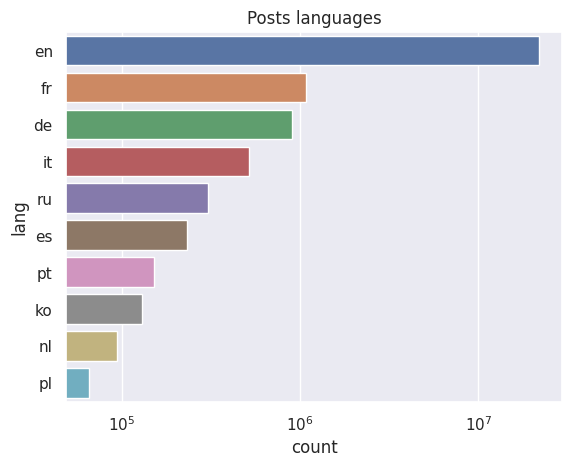

In [206]:
lang_count = index_df['lang'].value_counts().to_frame().reset_index()

ax = sns.barplot(lang_count.head(10), y='lang', x='count', hue='lang')
ax.set_title('Posts languages')
ax.set_xscale('log')

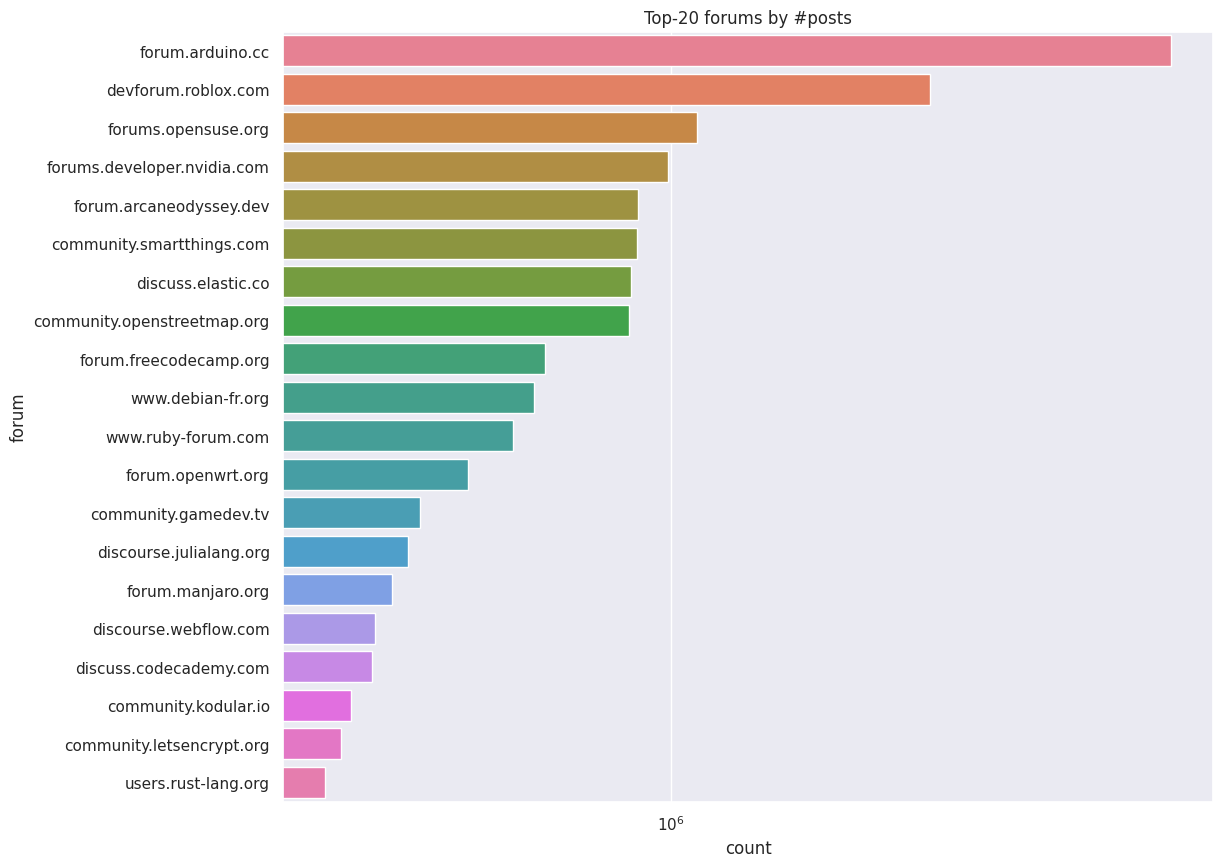

In [227]:
forum_count = index_df['forum'].value_counts().to_frame().reset_index()

plt.figure(figsize=(12,10))
ax = sns.barplot(forum_count.head(20), y='forum', x='count', hue='forum')
ax.set_title('Top-20 forums by #posts')
ax.set_xscale('log')

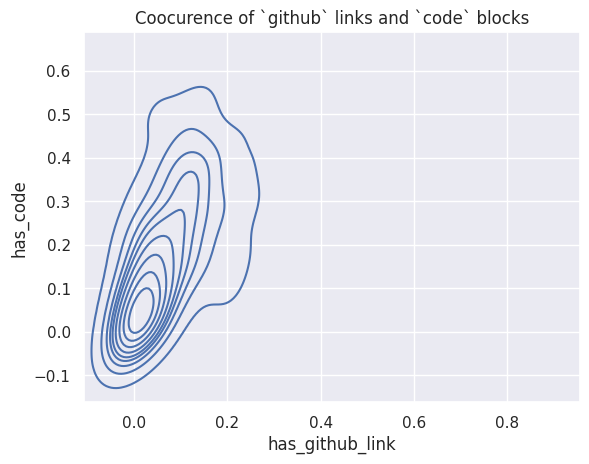

In [255]:
ax = sns.kdeplot(index_df.groupby('forum')[['has_github_link','has_code']].mean(),
                 x='has_github_link', y='has_code')
_ = ax.set_title('Coocurence of `github` links and `code` blocks')

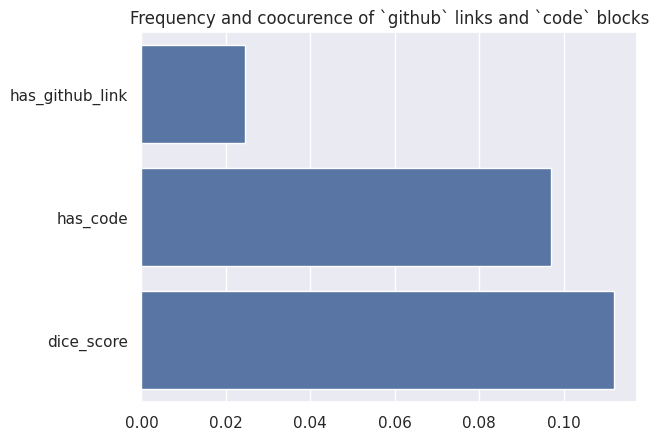

In [253]:
ax = sns.barplot(dict( has_github_link= index_df['has_github_link'].mean(),
                 has_code= index_df['has_code'].mean(),
                 dice_score = 2* (index_df['has_github_link'] & index_df['has_code']).sum() \
    / (index_df['has_github_link'].sum() + index_df['has_code'].sum())
), orient='h')
_ = ax.set_title('Frequency and coocurence of `github` links and `code` blocks')

Text(0.5, 1.0, 'Log-distribution of likes')

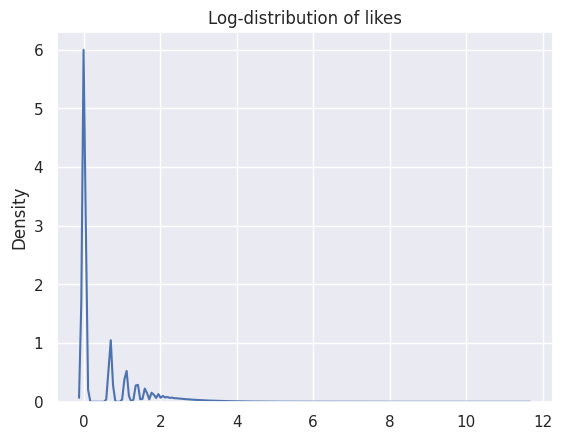

In [268]:
ax = sns.kdeplot(np.log1p(pd.Series(dataset['topic_likes']).dropna()))
ax.set_title('Log-distribution of likes')

Text(0.5, 1.0, 'Log-distribution of views')

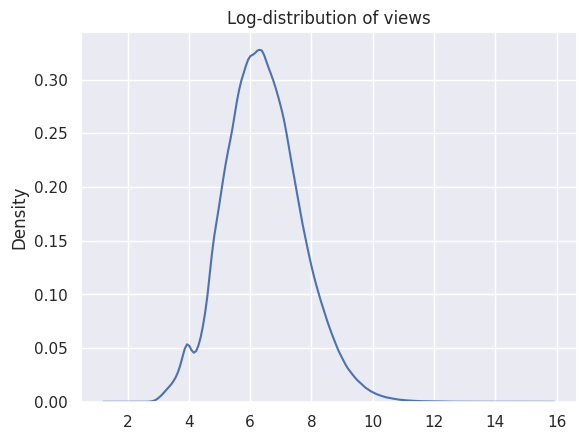

In [269]:
ax = sns.kdeplot(np.log1p(pd.Series(dataset['topic_views']).dropna()))
ax.set_title('Log-distribution of views')